In [53]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

import shapely
from shapely.geometry import Point, box
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

In [84]:
dataOcc = "data/0080202-250525065834625.csv"
essential_cols = ["decimallatitude", "decimallongitude", "specieskey"]
df = pd.read_csv(dataOcc, usecols=essential_cols, sep="\t")
df.dropna(subset=["decimallatitude", "decimallongitude", "specieskey"], inplace=True)

In [85]:
df

,decimallatitude,decimallongitude,specieskey
0,50.83600,4.38500,1316908
1,50.83600,4.38500,1314773
2,50.83600,4.38500,1326634
3,50.83600,4.38500,1326634
4,50.83600,4.38500,1326634
...,...,...,...
11817,50.87618,4.74119,2037991
11818,50.74768,4.24028,2020686
11819,50.78927,4.52514,2020686
11820,50.74768,4.24028,2020686


In [10]:
df["geometry"] = [Point(xy) for xy in zip(df.decimallongitude, df.decimallatitude)]
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3035")  # Use metric projection

In [11]:
df

,decimallatitude,decimallongitude,specieskey,geometry
0,50.83600,4.38500,1316908,POINT (4.385 50.836)
1,50.83600,4.38500,1314773,POINT (4.385 50.836)
2,50.83600,4.38500,1326634,POINT (4.385 50.836)
3,50.83600,4.38500,1326634,POINT (4.385 50.836)
4,50.83600,4.38500,1326634,POINT (4.385 50.836)
...,...,...,...,...
11817,50.87618,4.74119,2037991,POINT (4.74119 50.87618)
11818,50.74768,4.24028,2020686,POINT (4.24028 50.74768)
11819,50.78927,4.52514,2020686,POINT (4.52514 50.78927)
11820,50.74768,4.24028,2020686,POINT (4.24028 50.74768)


In [12]:
gdf

,decimallatitude,decimallongitude,specieskey,geometry
0,50.83600,4.38500,1316908,POINT (3925887.975 3095667.337)
1,50.83600,4.38500,1314773,POINT (3925887.975 3095667.337)
2,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337)
3,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337)
4,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337)
...,...,...,...,...
11817,50.87618,4.74119,2037991,POINT (3951219.611 3098264.526)
11818,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641)
11819,50.78927,4.52514,2020686,POINT (3935341.66 3089733.677)
11820,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641)


In [52]:
gdf.total_bounds

array([3910136.44376937, 3077106.17253917, 3951347.08850828,
       3101409.35201596])

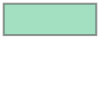

In [54]:
test_bbox = (4.171371,50.684060,4.743004,50.877911)
test_bbox = shapely.geometry.box(*test_bbox)
test_bbox

In [58]:
import pyproj
# Define the transformation from WGS84 to EPSG:3035 (ETRS89 / LAEA Europe)
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True).transform
# Apply the transformation to the shapely geometry
projected_geom = transform(project, test_bbox)
print(projected_geom.bounds)

TypeError: 'Affine' object is not callable

In [59]:
project = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True).transform

In [65]:
from shapely.geometry import box
from shapely.ops import transform
import pyproj

# Define your bbox in EPSG:4326 (WGS84)
test_bbox = (4.171371, 50.684060, 4.743004, 50.877911)
test_bbox = box(*test_bbox)

# Use a new, safe variable name for the transform function
project_fn = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3035", always_xy=True).transform

# Apply the projection
projected_geom = transform(project_fn, test_bbox)

# Print the projected bbox
print(projected_geom.bounds)

(3909555.975051567, 3076929.811885927, 3951360.653593751, 3101493.042453728)


In [13]:
# --- Create 1x1 km grid ---
minx, miny, maxx, maxy = gdf.total_bounds
cell_size = 1000
width = int((maxx - minx) / cell_size)
height = int((maxy - miny) / cell_size)
transform = from_origin(minx, maxy, cell_size, cell_size)

In [14]:
minx, miny

(np.float64(3910136.4437693707), np.float64(3077106.1725391727))

In [15]:
maxx, maxy

(np.float64(3951347.088508277), np.float64(3101409.352015964))

In [16]:
width, height

(41, 24)

rasterio.transform.from_origin(west, north, xsize, ysize)

Return an Affine transformation given upper left and pixel sizes.

Return an Affine transformation for a georeferenced raster given the coordinates of its upper left corner west, north and pixel sizes xsize, ysize.

In [17]:
transform

Affine(1000.0, 0.0, np.float64(3910136.4437693707),
       0.0, -1000.0, np.float64(3101409.352015964))

In [18]:
grid_cells = [
    box(x0, y0, x0 + cell_size, y0 + cell_size)
    for x0 in np.arange(minx, maxx, cell_size)
    for y0 in np.arange(miny, maxy, cell_size)
]

Polygon returned by the box function consists of 5 points (clockwise points from the min, i.e. [x_min y_min, x_min (y_min+c_y), (x_min + c_x) (y_min+c_y), ...]) the fifth point is the original point again, to close the polygon 

In [22]:
str(grid_cells[0])

'POLYGON ((3911136.4437693707 3077106.1725391727, 3911136.4437693707 3078106.1725391727, 3910136.4437693707 3078106.1725391727, 3910136.4437693707 3077106.1725391727, 3911136.4437693707 3077106.1725391727))'

In [24]:
grid = gpd.GeoDataFrame({"geometry": grid_cells}, crs="EPSG:3035")
grid["grid_id"] = grid.index

In [100]:
grid

,geometry,grid_id
0,"POLYGON ((3911136.444 3077106.173, 3911136.444...",0
1,"POLYGON ((3911136.444 3078106.173, 3911136.444...",1
2,"POLYGON ((3911136.444 3079106.173, 3911136.444...",2
3,"POLYGON ((3911136.444 3080106.173, 3911136.444...",3
4,"POLYGON ((3911136.444 3081106.173, 3911136.444...",4
...,...,...
1045,"POLYGON ((3952136.444 3097106.173, 3952136.444...",1045
1046,"POLYGON ((3952136.444 3098106.173, 3952136.444...",1046
1047,"POLYGON ((3952136.444 3099106.173, 3952136.444...",1047
1048,"POLYGON ((3952136.444 3100106.173, 3952136.444...",1048


In [107]:
str(grid.iloc[393]["geometry"])

'POLYGON ((3926136.4437693707 3095106.1725391727, 3926136.4437693707 3096106.1725391727, 3925136.4437693707 3096106.1725391727, 3925136.4437693707 3095106.1725391727, 3926136.4437693707 3095106.1725391727))'

In [ ]:
gdf[

In [101]:
joined = gpd.sjoin(gdf, grid, how="inner", predicate="within")
joined

,decimallatitude,decimallongitude,specieskey,geometry,index_right,grid_id
0,50.83600,4.38500,1316908,POINT (3925887.975 3095667.337),393,393
1,50.83600,4.38500,1314773,POINT (3925887.975 3095667.337),393,393
2,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),393,393
3,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),393,393
4,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),393,393
...,...,...,...,...,...,...
11817,50.87618,4.74119,2037991,POINT (3951219.611 3098264.526),1046,1046
11818,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641),109,109
11819,50.78927,4.52514,2020686,POINT (3935341.66 3089733.677),637,637
11820,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641),109,109


In [33]:
agg = (
    joined.groupby(["grid_id", "specieskey"])
    .size()
    .reset_index(name="occurrence_count")
)
agg

,grid_id,specieskey,occurrence_count
0,2,1311477,1
1,3,1311477,4
2,6,1311477,3
3,8,1311477,3
4,9,1047536,1
...,...,...,...
1900,1046,1326634,4
1901,1046,1690429,35
1902,1046,2020686,4
1903,1046,2037991,2


In [34]:
# Merge grid geometry back into aggregated results
agg = pd.merge(agg, grid[["grid_id", "geometry"]], on="grid_id")
agg = gpd.GeoDataFrame(agg, geometry="geometry", crs="EPSG:3035")
agg

,grid_id,specieskey,occurrence_count,geometry
0,2,1311477,1,"POLYGON ((3911136.444 3079106.173, 3911136.444..."
1,3,1311477,4,"POLYGON ((3911136.444 3080106.173, 3911136.444..."
2,6,1311477,3,"POLYGON ((3911136.444 3083106.173, 3911136.444..."
3,8,1311477,3,"POLYGON ((3911136.444 3085106.173, 3911136.444..."
4,9,1047536,1,"POLYGON ((3911136.444 3086106.173, 3911136.444..."
...,...,...,...,...
1900,1046,1326634,4,"POLYGON ((3952136.444 3098106.173, 3952136.444..."
1901,1046,1690429,35,"POLYGON ((3952136.444 3098106.173, 3952136.444..."
1902,1046,2020686,4,"POLYGON ((3952136.444 3098106.173, 3952136.444..."
1903,1046,2037991,2,"POLYGON ((3952136.444 3098106.173, 3952136.444..."


In [35]:
# --- Prepare raster ---
species_keys = agg["specieskey"].unique()
species_keys.sort()  # Optional: consistent band order
num_bands = len(species_keys)
raster_data = np.zeros((num_bands, height, width), dtype=np.uint16)
raster_data

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [39]:
# --- Rasterize each species band ---
for i, species in enumerate(species_keys):
    species_geom = agg[agg["specieskey"] == species]
    shapes = zip(species_geom.geometry, species_geom["occurrence_count"])
    band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint16"
    )
    raster_data[i] = band

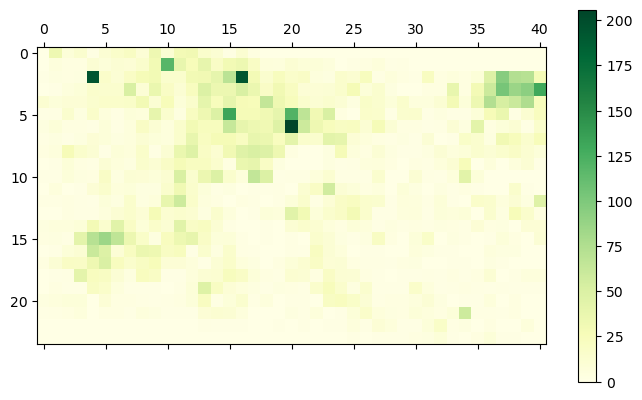

In [51]:
import matplotlib.pyplot as plt
plt.matshow(np.sum(raster_data, axis=0), cmap="YlGn")
plt.colorbar()

# Making grid cells within a given spatial extent

In [98]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

import shapely
from shapely.geometry import Point, box
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
from itertools import product

def format_dataframe(df, begin_crs, end_crs, long_lat_keys=["decimallongitude", "decimallatitude"]):
    """
    A function that transforms the original dataframe to a geopandas dataframe where we reproject the data to a new coordinate reference system.
    The old table is extended with a geometry column that assigns each record to a point geometry in the end coordinate reference system

    Args
        data (pandas.DataFrame): A pandas dataframe containing the data of interest which is characterized in terms of coordinates that correspond to the begin_crs
        begin_crs (str): A string that describes the original coordinate reference system that is being used in the data.
        end_crs (str): A string that describes the target coordinates reference system that the user wishes to use.
    Returns
        gdf (geopandas.GeoDataFrame): A geopandas dataframe where each record has a point geometry associated with it
    """
    # Assign a point geometry to each record in the dataframe
    df["geometry"] = [Point(xy) for xy in zip(df[long_lat_keys[0]], df[long_lat_keys[1]])]
    
    # Convert the dataframe to a geodataframe
    gdf = gpd.GeoDataFrame(df, geometry="geometry", crs=begin_crs)
    
    # Reproject the coordinate reference system to the desired system
    gdf = gdf.to_crs(end_crs)
    return gdf
    
def rasterize_data(data, polygon, begin_crs, end_crs, cell_size, long_lat_keys=["decimallongitude", "decimallatitude"]):
    """
    Constructs a grid of square cells in a given bounding box with the possibility to transform in between coordinate 
    reference systems

    Args
        data (pandas.DataFrame): A pandas dataframe containing the data of interest which is characterized in terms of coordinates that correspond to the begin_crs
        polygon (shapely.geometry.polygon.Polygon): A bounding box that describes the area of interest/sampled area. 
                                                    The format should be done within standard order of coordinates, i.e. (long_min, lat_min, long_max, lat_max)
        begin_crs (str): A string that describes the original coordinate reference system that is being used in the data.
        end_crs (str): A string that describes the target coordinates reference system that the user wishes to use.
        cell_size (int): An integer that expresses the size of the square cells in meters.
    Returns
        grid (geopandas.GeoDataFrame): A geopandas dataframe where each record is assigned to one of the grid cells in the constructed grid
    """
    # Define the projection function that will be used to convert the bbox from the original CRS to the target CRS
    # always_xy=True, If true, the transform method will accept as input and return as output coordinates using the 
    #traditional GIS order, that is longitude, latitude for geographic CRS
    project_fn = pyproj.Transformer.from_crs(begin_crs, end_crs, always_xy=True).transform

    # Apply the projection to the bbox 
    projected_geom = transform(project_fn, polygon)

    # Extract the minimum and maximum coordinates from the geometry
    minx, miny, maxx, maxy = projected_geom.bounds

    # Construct the individual grid cells by adding the cell size from the minimum value to the maximum value
    grid_cells = [box(x, y, x + cell_size, y + cell_size) for x, y in product(np.arange(minx, maxx, cell_size), np.arange(miny, maxy, cell_size))]
    
    # Store the grid within a geopandas dataframe
    grid = gpd.GeoDataFrame({"geometry": grid_cells}, crs=end_crs)
    grid["grid_id"] = grid.index

    # Convert the dataframe to a geopandas dataframe
    geodata = format_dataframe(data, begin_crs, end_crs, long_lat_keys=long_lat_keys)

    #Combine the grid with the data so that each point is assigned a grid idx based on whether it is within one of the cells of the grid
    #Inner keeps all data that satifies the predicate
    raster_data = gpd.sjoin(geodata, grid, how="inner", predicate="within")
    
    # Clean up the dataframe by removing the redundant column
    raster_data = raster_data.drop("index_right", axis=1)
    return raster_data

#def process_occurence_raster(rasterdata, groupingkey="specieskey"):
    

In [88]:
format_dataframe(df,"EPSG:4326", "EPSG:3035")

,decimallatitude,decimallongitude,specieskey,geometry
0,50.83600,4.38500,1316908,POINT (3925887.975 3095667.337)
1,50.83600,4.38500,1314773,POINT (3925887.975 3095667.337)
2,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337)
3,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337)
4,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337)
...,...,...,...,...
11817,50.87618,4.74119,2037991,POINT (3951219.611 3098264.526)
11818,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641)
11819,50.78927,4.52514,2020686,POINT (3935341.66 3089733.677)
11820,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641)


In [99]:
test_bbox = (4.171371, 50.684060, 4.743004, 50.877911)
test_bbox = box(*test_bbox)
rasterize_data(df, test_bbox,"EPSG:4326", "EPSG:3035", 1000)

,decimallatitude,decimallongitude,specieskey,geometry,grid_id
0,50.83600,4.38500,1316908,POINT (3925887.975 3095667.337),418
1,50.83600,4.38500,1314773,POINT (3925887.975 3095667.337),418
2,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),418
3,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),418
4,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),418
...,...,...,...,...,...
11817,50.87618,4.74119,2037991,POINT (3951219.611 3098264.526),1046
11818,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641),134
11819,50.78927,4.52514,2020686,POINT (3935341.66 3089733.677),637
11820,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641),134


,decimallatitude,decimallongitude,specieskey,geometry,grid_id
0,50.83600,4.38500,1316908,POINT (3925887.975 3095667.337),418
1,50.83600,4.38500,1314773,POINT (3925887.975 3095667.337),418
2,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),418
3,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),418
4,50.83600,4.38500,1326634,POINT (3925887.975 3095667.337),418
...,...,...,...,...,...
11817,50.87618,4.74119,2037991,POINT (3951219.611 3098264.526),1046
11818,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641),134
11819,50.78927,4.52514,2020686,POINT (3935341.66 3089733.677),637
11820,50.74768,4.24028,2020686,POINT (3914960.978 3086659.641),134


In [72]:
grid_cells = [
    box(x0, y0, x0 + cell_size, y0 + cell_size)
    for x0 in np.arange(minx, maxx, cell_size)
    for y0 in np.arange(miny, maxy, cell_size)]
len(grid_cells)

1050

In [69]:
from itertools import product

polygons = [box(x, y, x + cell_size, y + cell_size) for x, y in product(np.arange(minx, maxx, cell_size), np.arange(miny, maxy, cell_size))]
polygons

[<POLYGON ((3911136.444 3077106.173, 3911136.444 3078106.173, 3910136.444 307...>,
 <POLYGON ((3911136.444 3078106.173, 3911136.444 3079106.173, 3910136.444 307...>,
 <POLYGON ((3911136.444 3079106.173, 3911136.444 3080106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3080106.173, 3911136.444 3081106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3081106.173, 3911136.444 3082106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3082106.173, 3911136.444 3083106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3083106.173, 3911136.444 3084106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3084106.173, 3911136.444 3085106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3085106.173, 3911136.444 3086106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3086106.173, 3911136.444 3087106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3087106.173, 3911136.444 3088106.173, 3910136.444 308...>,
 <POLYGON ((3911136.444 3088106.173, 3911136.444 3089106.173, 3910136.444 308...>,
 <PO

In [70]:
len(polygons)

1050

In [73]:
grid_cells == polygons

True